# Clustering tutorial 

This tutorial demonstrates the experimental clustering API for capymoa. 
Clustering data streams refers to grouping data points into clusters as the data continuously flows in, which normally includes two phases: 


1. **Online Step** 
    1. **Micro-Cluster Formation**: Incoming data points are incrementally processed and assigned to micro-clusters. Micro-clusters are small, temporary clusters that capture local density information and are typically represented by statistical summaries like centroid, weight, and radius.

    2. **Micro-Cluster Maintenance**: The micro-clusters are periodically updated as new data arrives. This includes adjusting the micro-cluster centroids and merging or splitting clusters based on defined thresholds.

2. **Offline Step**: Periodically or upon request, micro-clusters are aggregated into macro-clusters (or simply clusters) to provide a higher-level view of the data.

<span style="color:red">This is an experimental API might change significantly in the near future. </span>

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 31/07/2024**

## 1. Creating and using a clusterer

- Example using `CluStream` and `kMeans` for the offline step
- There is not evaluation included in the example below, just updating and plotting the cluster
- The data is generated using `RandomRBFGeneratorDrift` 
- We use a visualization function to print the clustering state

In [1]:
from capymoa.clusterers import Clustream_with_kmeans as WithKmeans
from capymoa.stream.generator import RandomRBFGeneratorDrift
from capymoa.evaluation.visualization import plot_clustering_state

stream = RandomRBFGeneratorDrift(
    number_of_attributes=2,
    number_of_centroids=5,
    number_of_drifting_centroids=1,
    magnitude_of_change=0.001,
)
clustream = WithKmeans(
    schema=stream.get_schema(),
    time_window=100,
    max_num_kernels=50,
    kernel_radi_factor=2,
    k_option=5,
)

Processed 100 instances.


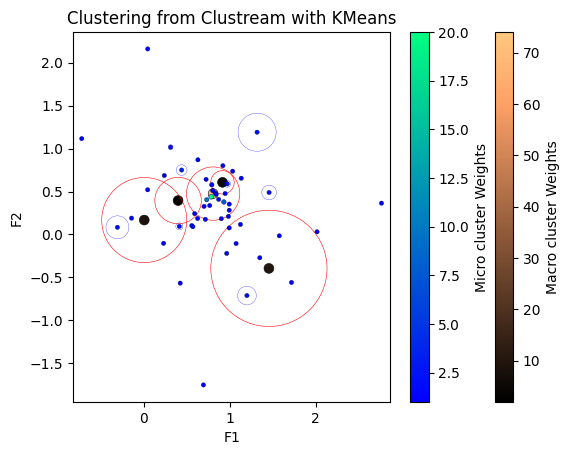

Processed 200 instances.


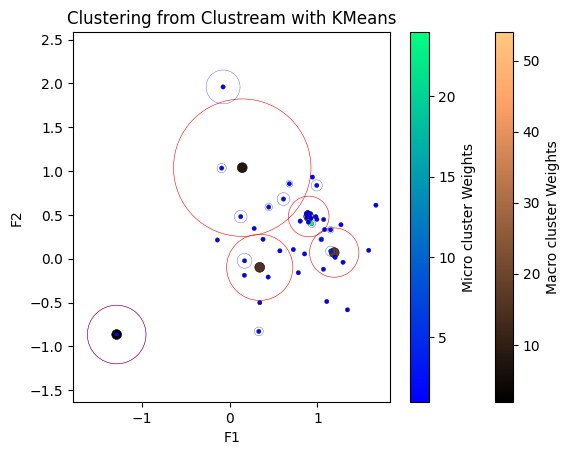

Processed 300 instances.


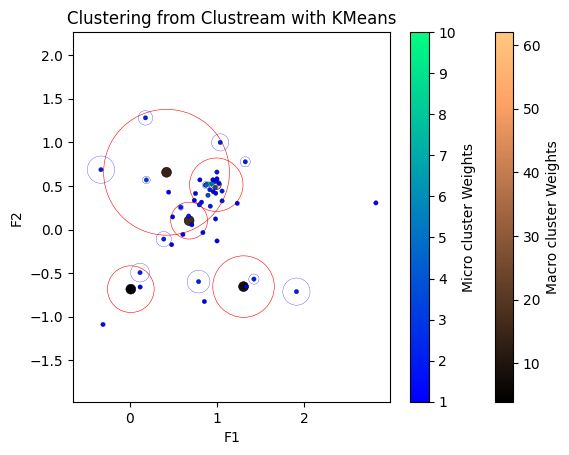

In [2]:
instancesSeen = 0
updateInterval = 100
while stream.has_more_instances() and instancesSeen < 300:
    instance = stream.next_instance()
    clustream.train(instance)
    instancesSeen += 1
    if instancesSeen % updateInterval == 0:
        print(f"Processed {instancesSeen} instances.")
        plot_clustering_state(clustream)
        # by default, plot_clustering_state only shows the image and does not save it

## 2. Using the Clustering Evaluator


In [3]:
from capymoa.evaluation import ClusteringEvaluator

In [4]:
stream = RandomRBFGeneratorDrift(
    number_of_attributes=2,
    number_of_centroids=10,
    number_of_drifting_centroids=1,
    magnitude_of_change=0.001,
)
clustream = WithKmeans(
    schema=stream.get_schema(),
    time_window=1000,
    max_num_kernels=25,
    kernel_radi_factor=2,
    k_option=5,
)
evaluator = ClusteringEvaluator(update_interval=100)

### 2.1 Plot the clustering state on demand

In [5]:
while stream.has_more_instances() and evaluator.get_instances_seen() < 1000:
    instance = stream.next_instance()
    clustream.train(instance)
    evaluator.update(clustream)
    instancesSeen = evaluator.get_instances_seen()
    # purposefully arbitrary number
    if instancesSeen == 157:
        # can also skip show and only save
        print(
            f"Processed {instancesSeen} instances. Saving the figure without showing it."
        )
        plot_clustering_state(
            clustream, show_fig=False, save_fig=True, figure_name="save_fig_dont_show"
        )

Processed 157 instances. Saving the figure without showing it.


### 2.2 Plot the clustering evolution (gif)

- Passing `clean_up=False` to the `plot_clustering_evolution` function will keep the intermediate figures used to create the gif.
- You need the `ClusteringEvaluator` to generate the gif.
- Default filename will be `<clusterer_name>_clustering_evolution.gif`

In [6]:
from capymoa.evaluation.visualization import plot_clustering_evolution

plot_clustering_evolution(evaluator, clean_up=True, frame_duration=1000)

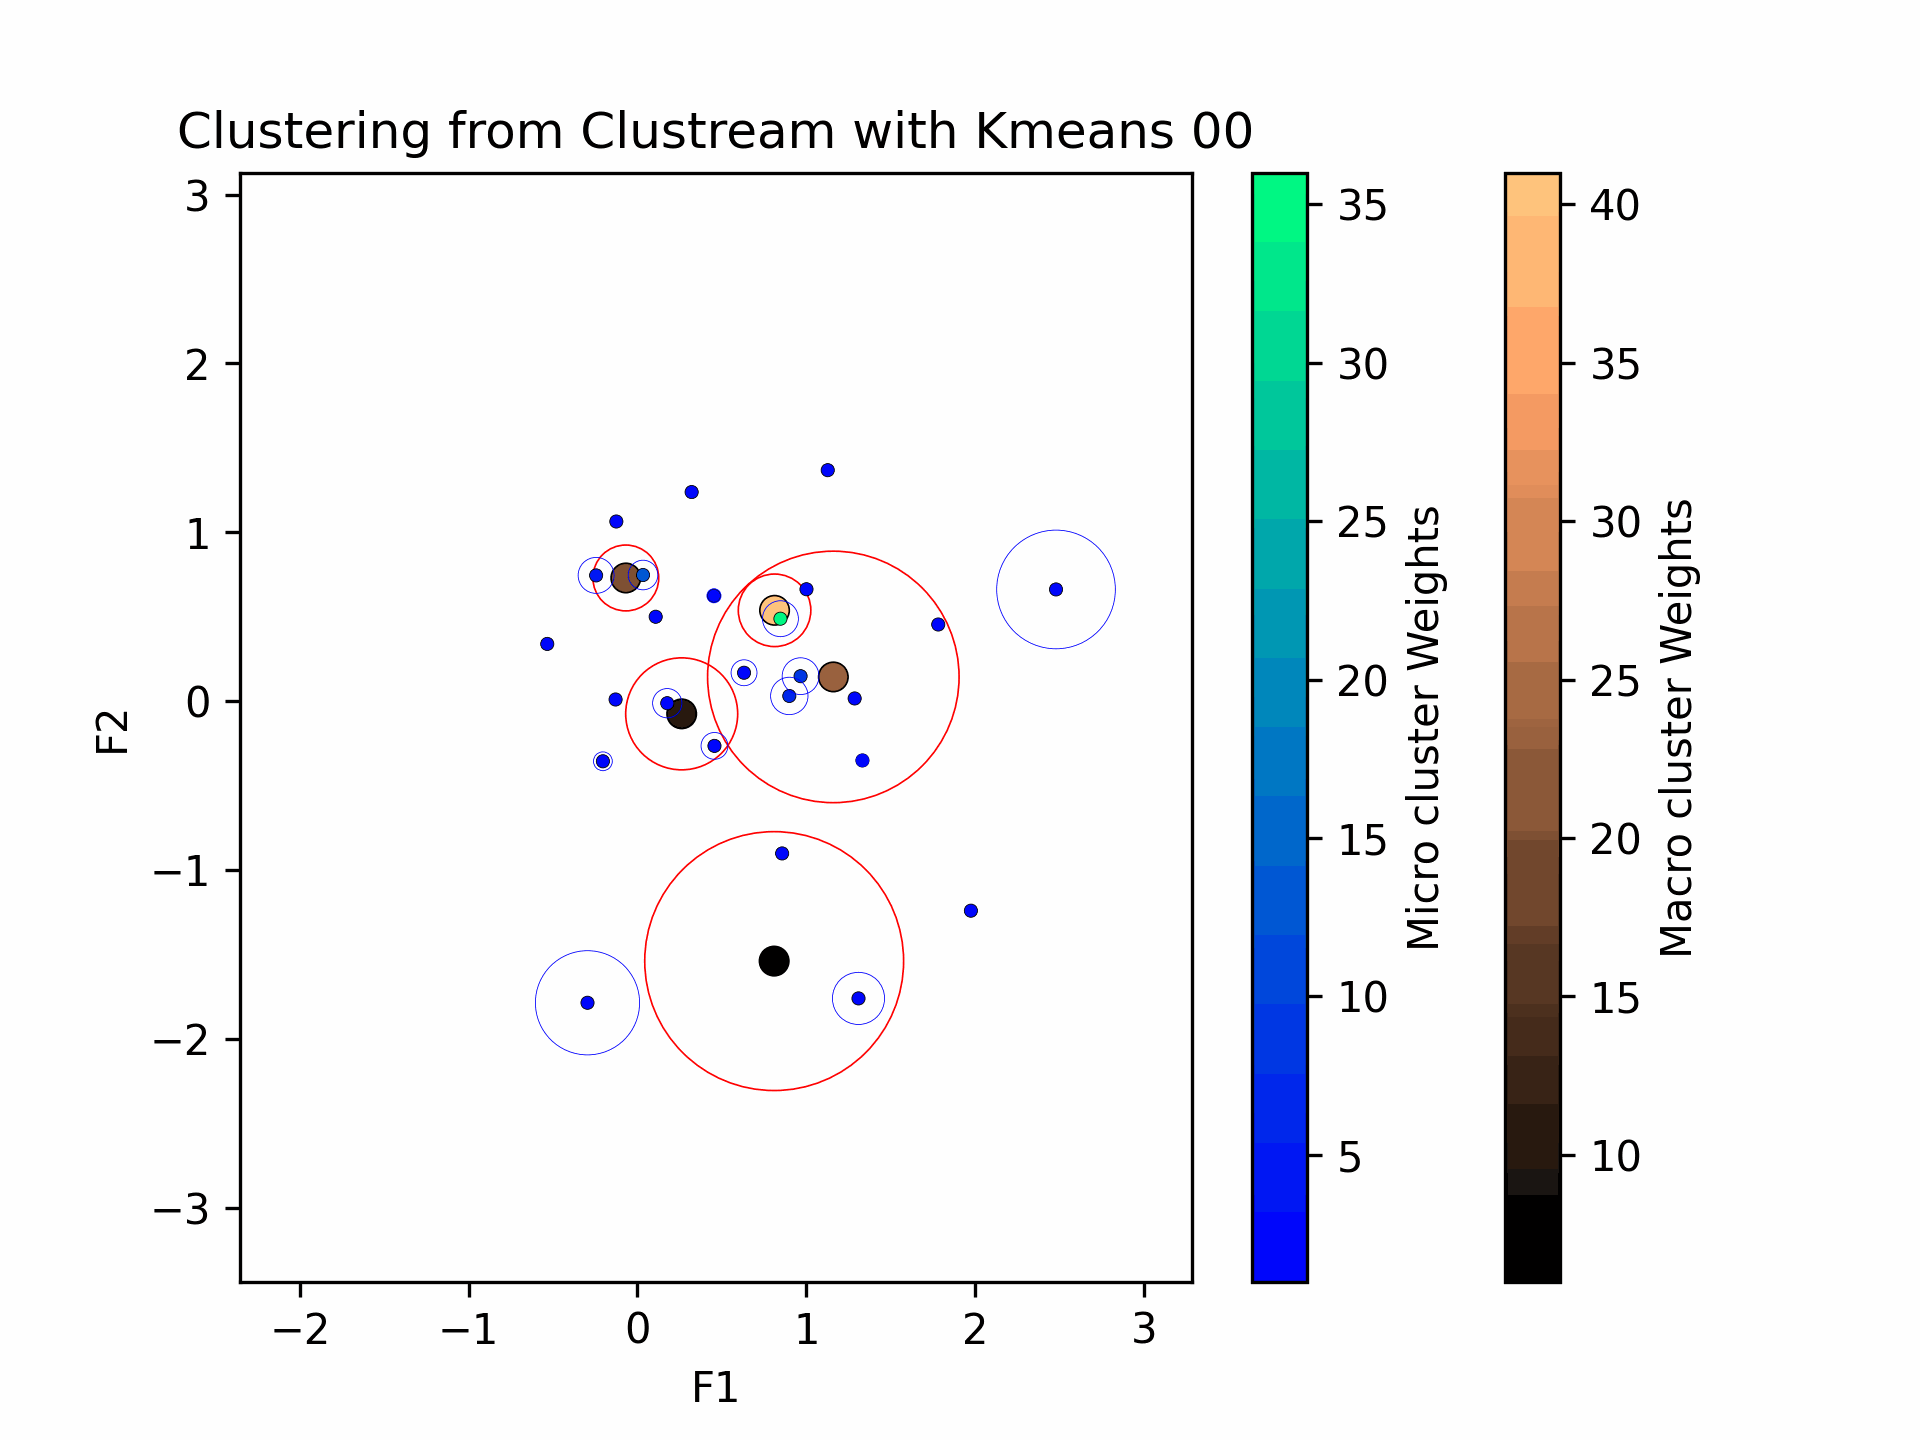

In [7]:
from IPython.display import Image

# Display the GIF
Image(filename="./Clustream_with_Kmeans_clustering_evolution.gif")

## 3. Using DenStream with DBSCAN


In [8]:
from capymoa.clusterers import Denstream_with_dbscan as Denstream

denstream = Denstream(
    schema=stream.get_schema(),
    horizon=1000,
    epsilon=0.04,
    beta=0.2,
    mu=1.2,
    init_points=100,
    offline_option=3,
    lambda_option=0.25,
    speed=200,
)
stream = RandomRBFGeneratorDrift(
    number_of_attributes=2,
    number_of_centroids=10,
    number_of_drifting_centroids=1,
    magnitude_of_change=0.001,
)
evaluator = ClusteringEvaluator(update_interval=100)

In [9]:
while stream.has_more_instances() and evaluator.get_instances_seen() < 1000:
    instance = stream.next_instance()
    denstream.train(instance)
    evaluator.update(denstream)
    instancesSeen = evaluator.get_instances_seen()

- You can choose the name of the gif file using the `filename` option

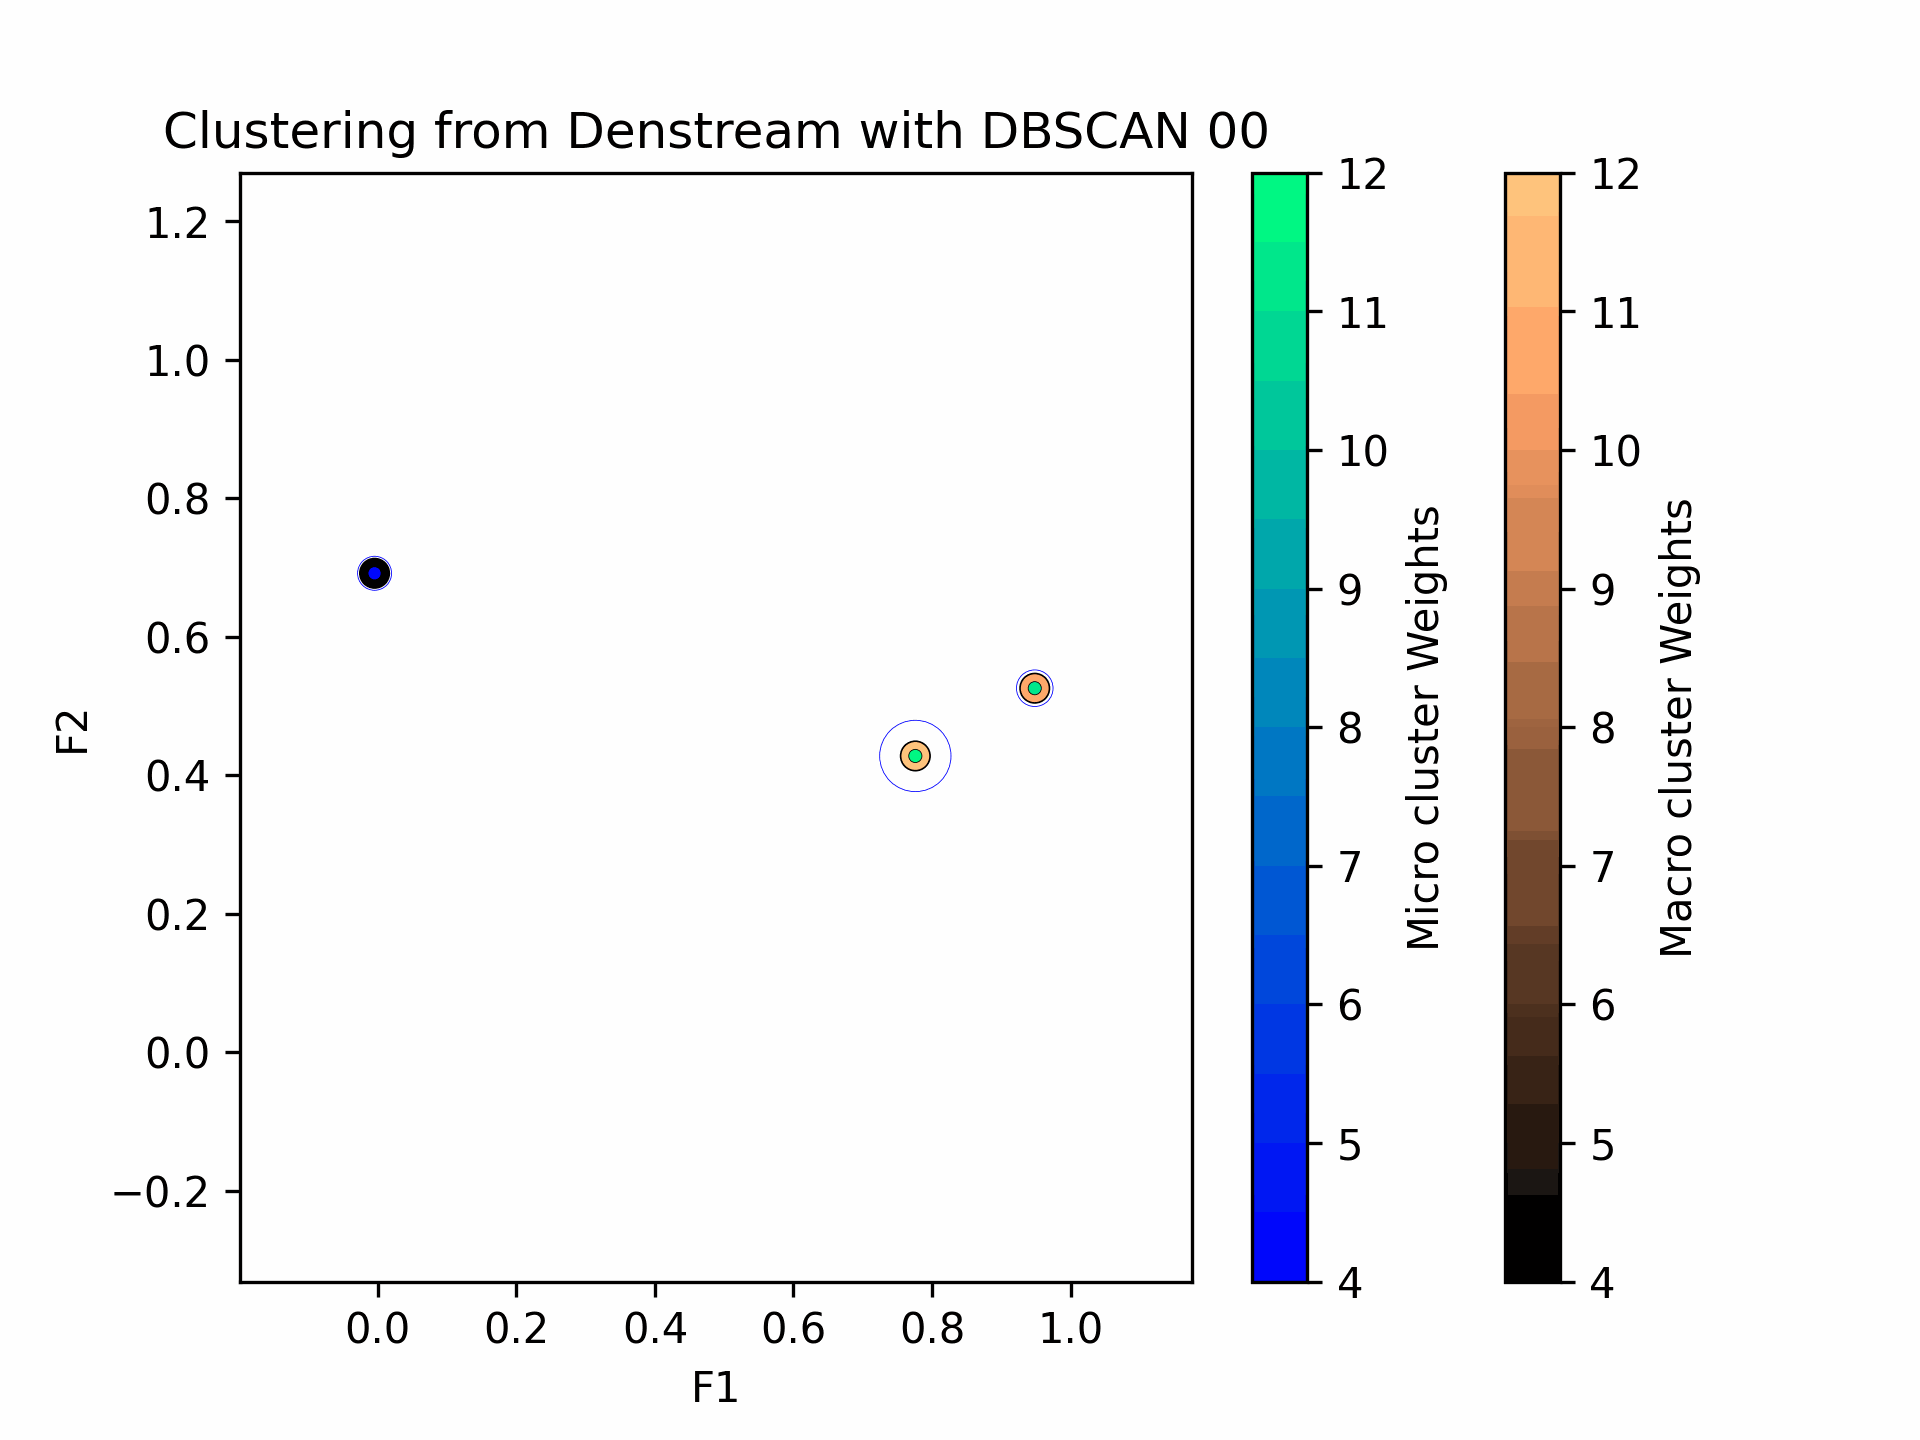

In [10]:
# This will save the clusterer as output
plot_clustering_evolution(
    evaluator, clean_up=True, filename="DeNSTReaM_clustering_custom_name.gif"
)
# Display the GIF
Image(filename="./DeNSTReaM_clustering_custom_name.gif")

## 4. Using Clustream without macro-clustering


In [11]:
from capymoa.clusterers import Clustream as ClustreamMicro

clustream_micro = ClustreamMicro(
    schema=stream.get_schema(),
    kernel_radi_factor=2,
    time_window=1000,
    max_num_kernels=25,
)
stream = RandomRBFGeneratorDrift(
    number_of_attributes=2,
    number_of_centroids=10,
    number_of_drifting_centroids=1,
    magnitude_of_change=0.001,
)
evaluator = ClusteringEvaluator(update_interval=100)

In [12]:
while stream.has_more_instances() and evaluator.get_instances_seen() < 1000:
    instance = stream.next_instance()
    clustream_micro.train(instance)
    evaluator.update(clustream_micro)
    instancesSeen = evaluator.get_instances_seen()

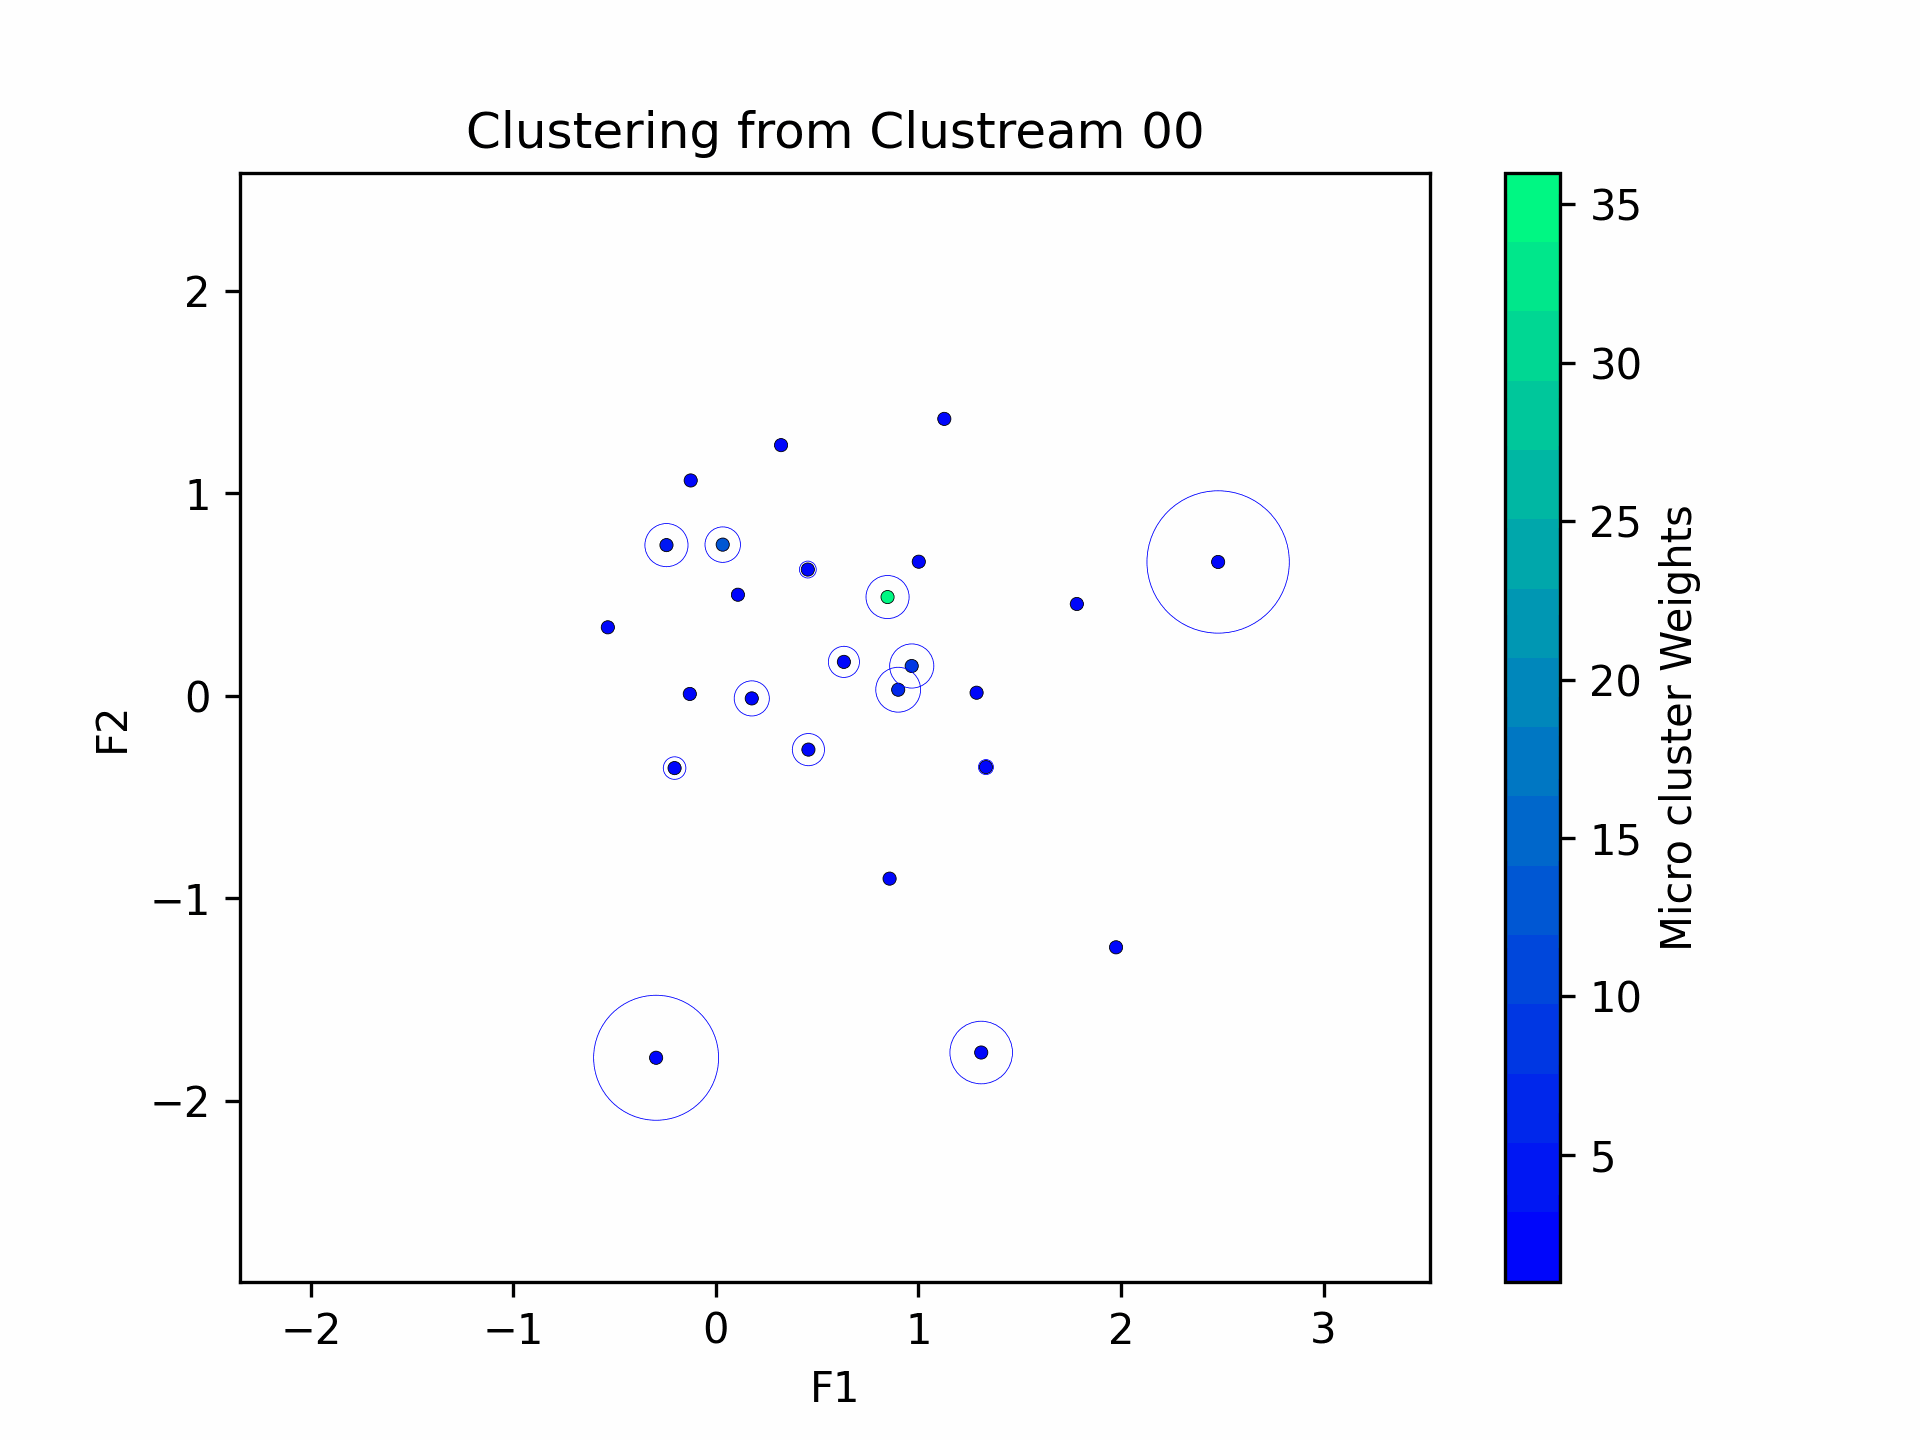

In [13]:
# This will save the clusterer as output
plot_clustering_evolution(evaluator, clean_up=True)
# Display the GIF
Image(filename="./Clustream_clustering_evolution.gif")

## 5. Using ClusTree

In [14]:
from capymoa.clusterers import ClusTree

clustree = ClusTree(
    schema=stream.get_schema(), horizon=500, max_height=7, breadth_first_strategy=True
)
stream = RandomRBFGeneratorDrift(
    number_of_attributes=2,
    number_of_centroids=10,
    number_of_drifting_centroids=1,
    magnitude_of_change=0.001,
)
evaluator = ClusteringEvaluator(update_interval=100)

In [15]:
while stream.has_more_instances() and evaluator.get_instances_seen() < 1000:
    instance = stream.next_instance()
    clustree.train(instance)
    evaluator.update(clustree)
    instancesSeen = evaluator.get_instances_seen()

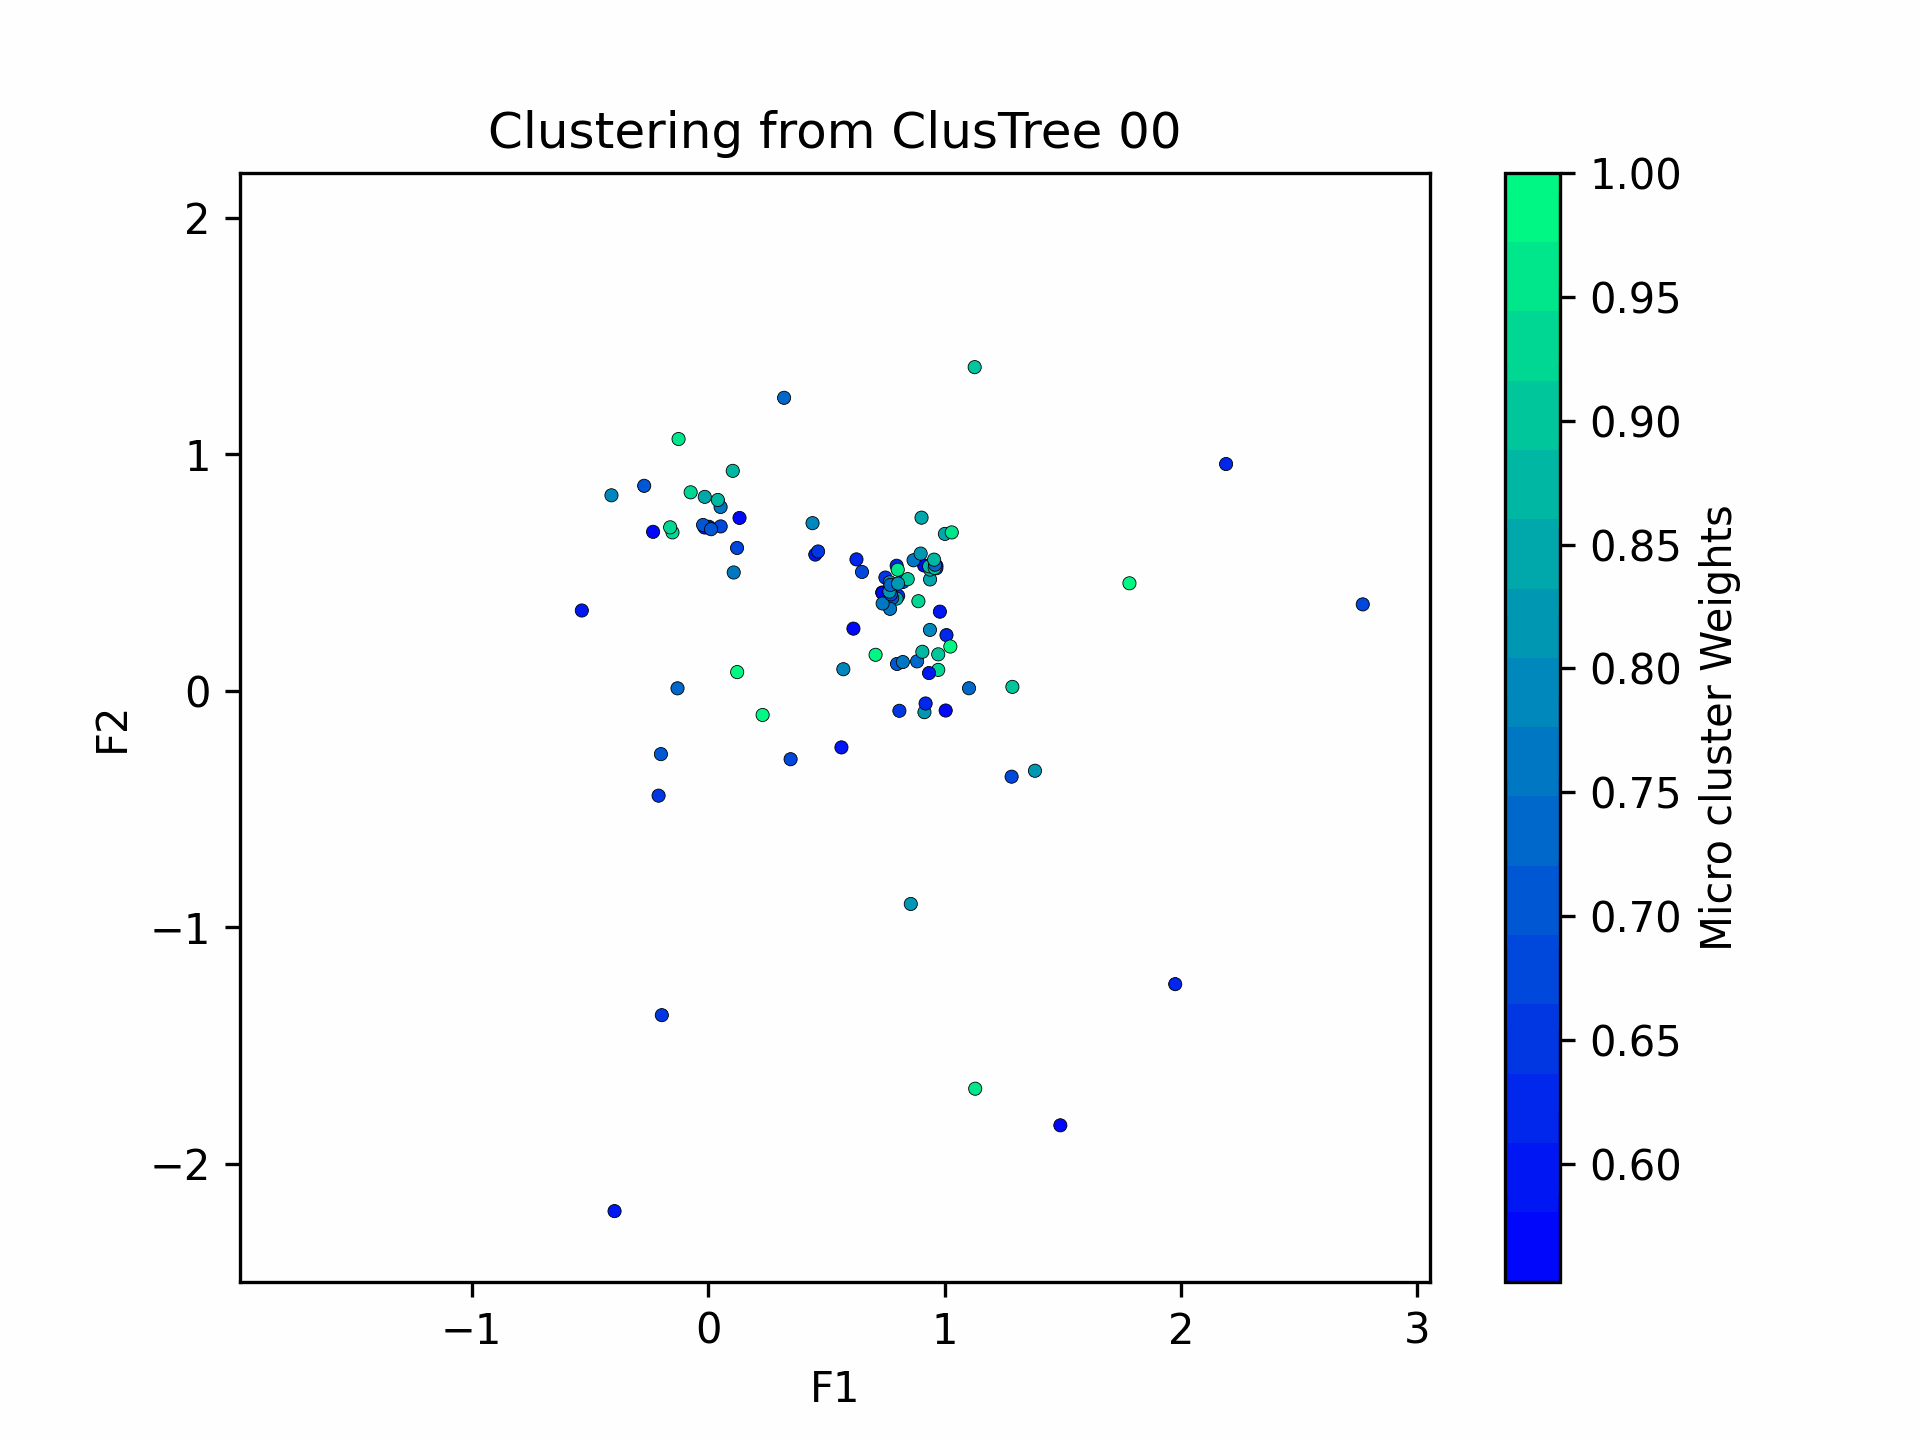

In [16]:
# This will save the clusterer as output
plot_clustering_evolution(evaluator, clean_up=True)
# Display the GIF
Image(filename="./ClusTree_clustering_evolution.gif")